In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import sys, os
import pickle
from torch import nn
import utils.trainutils as tutils
import utils.datautils as dutils
import utils.uqutils as uqutils
import models
from tqdm import tqdm_notebook
import torch.nn.functional as F
from scipy.special import comb
from matplotlib import pyplot as plt

# SETUP GPU
torch.backends.cudnn.benchmark = True
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)
base = os.path.join(os.getcwd(), 'data')
if not os.path.exists(base):
    os.mkdir(base)
print(f'Chosen data directory is {base}')

Chosen data directory is /home/rahul/lab_work/uq_deep_ensemble/data


Helper functions for printing different metrics and a function to return the reliability curve for a given pair of probability and target.

In [2]:
def pretty_print_uq(uq_tuple, init_str='Performance'):
    print(f'{init_str} ==> Accuracy {uq_tuple[0]*100:.2f}%,  '
     f'ECE {uq_tuple[1]*100:.2f}%,  '
     f'NLL {uq_tuple[2]:.4f},  '
     f'Brier {uq_tuple[3]:.4f}'
     )

def get_reliability_curve(probs, targets, fn=abs, bins=30):
    preds = np.argmax(probs, axis=1)
    correct = (preds == targets)
    maxprobs = np.max(probs, axis=-1)
    ece_correct, ece_total, ece = uqutils.calculate_ece(maxprobs, correct, nbin=bins, fn=fn)
    xs = np.arange(bins+1)/bins
    ys = [correct/total - x if total >= 5 else 0 for correct,total,x in zip(ece_correct, ece_total, xs)]
    return np.array(xs), np.array(ys)

### Dataloader and inference

In the following cell, we define our dataloaders, `start` denotes *ntrain* (number of training dataset), `end` denotes *nvalid* (number of validation dataset). To allow for various possible choices of validation dataset, keep `end` much higher than *nvalid*. Make sure that the `train_shuffle` and `valid_shuffle` is `False` in order for the inference to work with Deep Ensembles.

Then define the `model_file_pattern` to be the name pattern of the models in the trained Deep Ensemble and initiate the `model`.

Finally, use the `infer_ensemble` method from `trainutils` to infer on the *train, test, validation* datasets. We use the train and validation datasets without augmentations.

In [3]:
loader_dict, num_class = dutils.return_loaders(base=base, dataset='CIFAR10', start=1000, end=1500, 
                                               train_shuffle=False, valid_shuffle=False)
np.random.seed(1)
# Model file naming pattern
model_file_pattern = 'CIFAR10_ntrain-1000_MixUpAlpha-1.0_id-*.model'
# Model definition
model = models.FastResNet().to(device)

# Infer on the test dataset
test_probs, test_targets, model_files = tutils.infer_ensemble(model_file_pattern=model_file_pattern, model=model, 
                                                              dataloader=loader_dict['test'], evalmode=False)

# Infer on the validation dataset
valid_probs, valid_targets, _ = tutils.infer_ensemble(model_file_pattern=model_file_pattern, model=model,
                                                      dataloader=loader_dict['no-augment_valid'], evalmode=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Number of files found: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Number of files found: 10


100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


### Evaluation of Pooled and invidual model

Here we evaluate the individual models and pooled models in terms of **Accuracy**, Expected Calibration Error **(ECE)**, Negative log-likelihood **(NLL)**, **Brier score**. We tabulate the *mean* performance and *stdev* performance for the individual models. We also show the performance of the pooled model by vanilla method **[A]**. Here we can already see that in terms of ECE, the pooled model is worse than individual models.

In [5]:
model_performance = []
# Vanilla pooling of test probabilities
pooled_test_prob = np.mean(test_probs, axis=0)

# Get UQ performance of individual models
for pred in test_probs:
    model_performance.append(uqutils.get_all_scores(pred, test_targets))

# Get mean and standard deviation of UQ performance
model_performance = np.array(model_performance)
mean_performance = np.mean(model_performance, axis=0)
std_performance = np.std(model_performance, axis=0)
pretty_print_uq(mean_performance, "Mean of individual performance")
pretty_print_uq(std_performance, "Stdev of individual performance")

# Get UQ performance of vanilla-pooled [A] probabilities
pooled_performance = uqutils.get_all_scores(pooled_test_prob, test_targets)
pretty_print_uq(pooled_performance, "Pooled model performance")

Mean of individual performance ==> Accuracy 66.73%,  ECE 7.54%,  NLL 1.0337,  Brier 0.4625
Stdev of individual performance ==> Accuracy 0.31%,  ECE 0.39%,  NLL 0.0080,  Brier 0.0034
Pooled model performance ==> Accuracy 70.28%,  ECE 13.49%,  NLL 0.9668,  Brier 0.4333


### Visualizing the reliability curve

We plot the reliability curve {*Conf* (**x-axis**) vs. *Acc - Conf* (**y-axis**)} for both the individual models (in blue) and the pooled model (in red). Note that, **y > 0** implies *under-confidence*, **y < 0** implies *over-confidence*. It can be seen in the plot that the pooled model is more under-confident than the individual models.

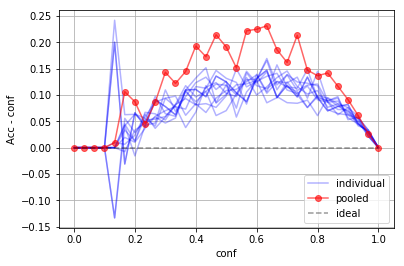

In [6]:
# Plot reliability curve of individual models
for i,pred in enumerate(test_probs):
    xs, ys = get_reliability_curve(pred, test_targets)
    if i==0:
        plt.plot(xs, ys, c='b', alpha=0.3, label='individual')
    plt.plot(xs, ys, c='b', alpha=0.3)

# Plot reliability curve of pooled model [A]
xs, ys = get_reliability_curve(pooled_test_prob, test_targets)
plt.plot(xs, ys, c='r', marker='o', alpha=0.6, label='pooled')
# Ideal line
plt.plot([0,1], [0,0], '--k', alpha=0.4, label='ideal')

plt.grid(axis='both')
plt.xlabel('conf')
plt.ylabel('Acc - conf')
plt.legend()

### *Pool-then-Calibrate*

We first show the difference in performance when we calibrate individual models and ensemble *after*, instead of pooling *first* and then calibrating. To do this we first fix a validation dataset. However, we show the variation of performance due to selection of different validation datasets later.

In the next cell we randomly choose a validation dataset that contains all the labels equal number of times. We use this sample for showing difference in performance. Later we will choose multiple sets of such samples. Set the variable `validation_samples` equal to the number of samples desired for the validation dataset.

In [7]:
# Number of samples to consider in the validation dataset
validation_samples = 50
# Number of samples per-class 
sample_per_class = validation_samples//num_class
# Indices corresponding to different labels
valid_target_idx = [np.where(valid_targets==i)[0] for i in range(num_class)]
# Sample equal number of indices belonging to each label
sample_indices = np.concatenate([np.random.choice(indices, 
                                                  replace=False, 
                                                  size=sample_per_class) for indices in valid_target_idx])

# Collate the validation dataset
valid_sample_prob = valid_probs[:,sample_indices,:]
valid_sample_targets = valid_targets[sample_indices]
# Pooled validation probability required for temperature scaling
valid_pooled_prob = np.mean(valid_sample_prob, axis=0)

Here we first perform *Pool-then-calibrate* method **[D]**. To do this, we first find out the optimal temperature $\tau_*$ using the method `uqutils.perform_tempscale` which performs --

$$
\tau_* = \underset{\tau_*}{\arg \min} \,\, \text{scale}\big[ \mathbf{Agg}(\mathbf{p}^{1:K}), \tau_* \big],
$$ 

i.e., finding optimal temperature from a range of temperatures by performing a linear search based on the negative log-likelihood on the validation dataset. The variable `pooled_temperature` holds the value for the found temperature $\tau_*$. Post that, we compare the performance of the unscaled pooled probability and the performance after scaling. Naturally, the found temperature $\tau_*$ is greater than 1. Hence, it sharpens the under-confident pooled probabilities.

In [8]:
# Temperature tau* found by Pool-then-Calibrate [D] method
pooled_temperature, _, _ = uqutils.perform_tempscale(valid_pooled_prob, valid_sample_targets)
# Scaling the pooled test probability with found tau*
pool_then_scale_test_prob = uqutils.prob_power_t(pooled_test_prob, pooled_temperature)
post_scaling_metrics = uqutils.get_all_scores(pool_then_scale_test_prob, test_targets)

pretty_print_uq(pooled_performance, "Pre tempscaling performance")
print(f"The temperature found by Pool-then-Calibrate [D] method is {pooled_temperature}")
pretty_print_uq(post_scaling_metrics, "Post tempscaling performance")

Pre tempscaling performance ==> Accuracy 70.28%,  ECE 13.49%,  NLL 0.9668,  Brier 0.4333
The temperature found by Pool-then-Calibrate [D] method is 1.6487212707001282
Post tempscaling performance ==> Accuracy 70.28%,  ECE 3.21%,  NLL 0.8971,  Brier 0.4088


Now with the same fixed validation sample, we perform individual temperature scaling of method **[B]**. To do that we find 
individual temperatures $\tau_*^{(k)}$ for each model $k$ by minimizing negative log-likelihood on the validation dataset 

$$
\tau_*^{(k)} = \underset{\tau}{\arg\min} \;  \frac{1}{\mathcal{D}_{\text{valid}}} \sum_{i \in \mathcal{D}_{\text{valid}}} 
\text{Score}\Big(\text{scale}\big[\mathbf{p}_i^{k}, \tau\big], y_i\Big).
$$

For each model we first find `individual_temperatures` of size $K$, and then use those temperatures to scale the test probabilities. The mean and standard deviation of the individual temperatures are printed. Then we measure the mean and standard deviation of the UQ performance for each scaled test probability (equivalently model). We then pool the different scaled test predictions scaled by $\tau_*^{(k)}$. The individual scaled model performance and the pooled performance are printed.

In [9]:
scaled_model_performance = []
individual_temperatures = []
modelwise_scaled_test_probs = []

# Perform individual temperature scaling for each model and store the temperatures
for prob in valid_sample_prob:
    individual_temperature, _, _ = uqutils.perform_tempscale(prob, valid_sample_targets)
    individual_temperatures.append(individual_temperature)

individual_temperatures = np.array(individual_temperatures)
print(f"Individual temperatures have mean: {np.mean(individual_temperatures)}"
      f", std: {np.std(individual_temperatures)}"
     )

# For each found temperature, scale the test probabilities with it and get UQ performance
for temp, test_p in zip(individual_temperatures, test_probs):
    scaled_prob = uqutils.prob_power_t(test_p, temp)
    scaled_model_performance.append(uqutils.get_all_scores(scaled_prob, test_targets))
    modelwise_scaled_test_probs.append(scaled_prob)

# Individual model performance after temperature scaling
scaled_model_performance = np.array(scaled_model_performance)
mean_performance = np.mean(scaled_model_performance, axis=0)
std_performance = np.std(scaled_model_performance, axis=0)
pretty_print_uq(mean_performance, "Mean of scaled individual performance")
pretty_print_uq(std_performance, "Stdev of scaled individual performance")

# Pool the individual temperature scaled probabilities (Calibrate-then-Pool [B] method)
modelwise_scaled_test_probs = np.stack(modelwise_scaled_test_probs, axis=0)
scale_then_pool_test_probs = np.mean(modelwise_scaled_test_probs, axis=0)
pool_after_scale_performance = uqutils.get_all_scores(scale_then_pool_test_probs, test_targets)
pretty_print_uq(pool_after_scale_performance, "Performance of Scale-then-Pool [B] is ")

Individual temperatures have mean: 1.3022722137408755, std: 0.11565239209870627
Mean of scaled individual performance ==> Accuracy 66.73%,  ECE 3.20%,  NLL 1.0157,  Brier 0.4563
Stdev of scaled individual performance ==> Accuracy 0.31%,  ECE 1.05%,  NLL 0.0088,  Brier 0.0034
Performance of Scale-then-Pool [B] is  ==> Accuracy 70.30%,  ECE 5.88%,  NLL 0.9077,  Brier 0.4131


We now visualize the reliability curve of **[B]** scaled models *(Calibrate-then-Pool)* and **[D]** scaled model *(Pool-then-Calibrate)*. Just like the plot in main text, the *light blue* curves corresponds to individually scaled (by $\tau_*^{(k)}$) reliability curves, the *orange* curves corresponds to individual curves after being scaled by common temperature $\tau_*$. We additionally show the curve of **[A]** (vanilla pooling without scaling) for comparison.

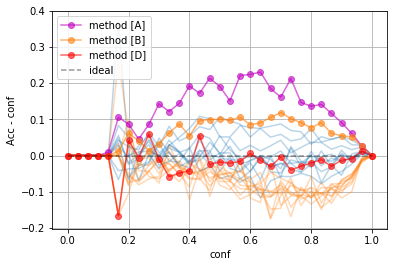

In [10]:
# For each model plot reliability curve
for temp, test_p in zip(individual_temperatures, test_probs):
    # reliability curve when scaled by individual temperatures
    scaled_prob = uqutils.prob_power_t(test_p, temp)
    xs, ys = get_reliability_curve(scaled_prob, test_targets)
    plt.plot(xs, ys, c='C0', alpha=0.3)
    
    # reliability curve when scaled by the common temperature
    scaled_prob = uqutils.prob_power_t(test_p, pooled_temperature)
    xs, ys = get_reliability_curve(scaled_prob, test_targets)
    plt.plot(xs, ys, c='C1', alpha=0.3)

# Reliability curve with vanilla pooling [A]
xs, ys = get_reliability_curve(pooled_test_prob, test_targets)
plt.plot(xs, ys, c='m', marker='o', alpha=0.6, label='method [A]')

# Reliability curve of Calibrate-then-Pool [B]
xs, ys = get_reliability_curve(scale_then_pool_test_probs, test_targets)
plt.plot(xs, ys, c='C1', marker='o', alpha=0.6, label='method [B]')

# Reliability curve of Pool-then-Calibrate [D]
xs, ys = get_reliability_curve(pool_then_scale_test_prob, test_targets)
plt.plot(xs, ys, c='r', marker='o', alpha=0.6, label='method [D]')

plt.plot([0,1], [0,0], '--k', alpha=0.4, label='ideal')
plt.grid(axis='both')
plt.xlabel('conf')
plt.ylabel('Acc - conf')
plt.legend(loc='upper left')